In [1]:
import os
import pandas as pd
from data.visualize import visualize_dataset
import numpy as np

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [2]:
def get_stock_df(df_all: pd.DataFrame, stock: str) -> pd.DataFrame:
    df = df_all[df_all['stock'] == stock]
    return df

In [3]:
def load_data_file(csv_file):
    if not os.path.exists(csv_file):
        raise FileNotFoundError(
            f"Please run data_fetcher.py to download the data first.")
    else:
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    return df
df_all = load_data_file("data/stock_testing_2023-01-01_2024-12-31.csv")
print(df_all["stock"].unique())

['NU' 'HIMS' 'RBLX' 'UPST' 'SE' 'CRWD' 'DDOG' 'SNOW' 'PLTR']


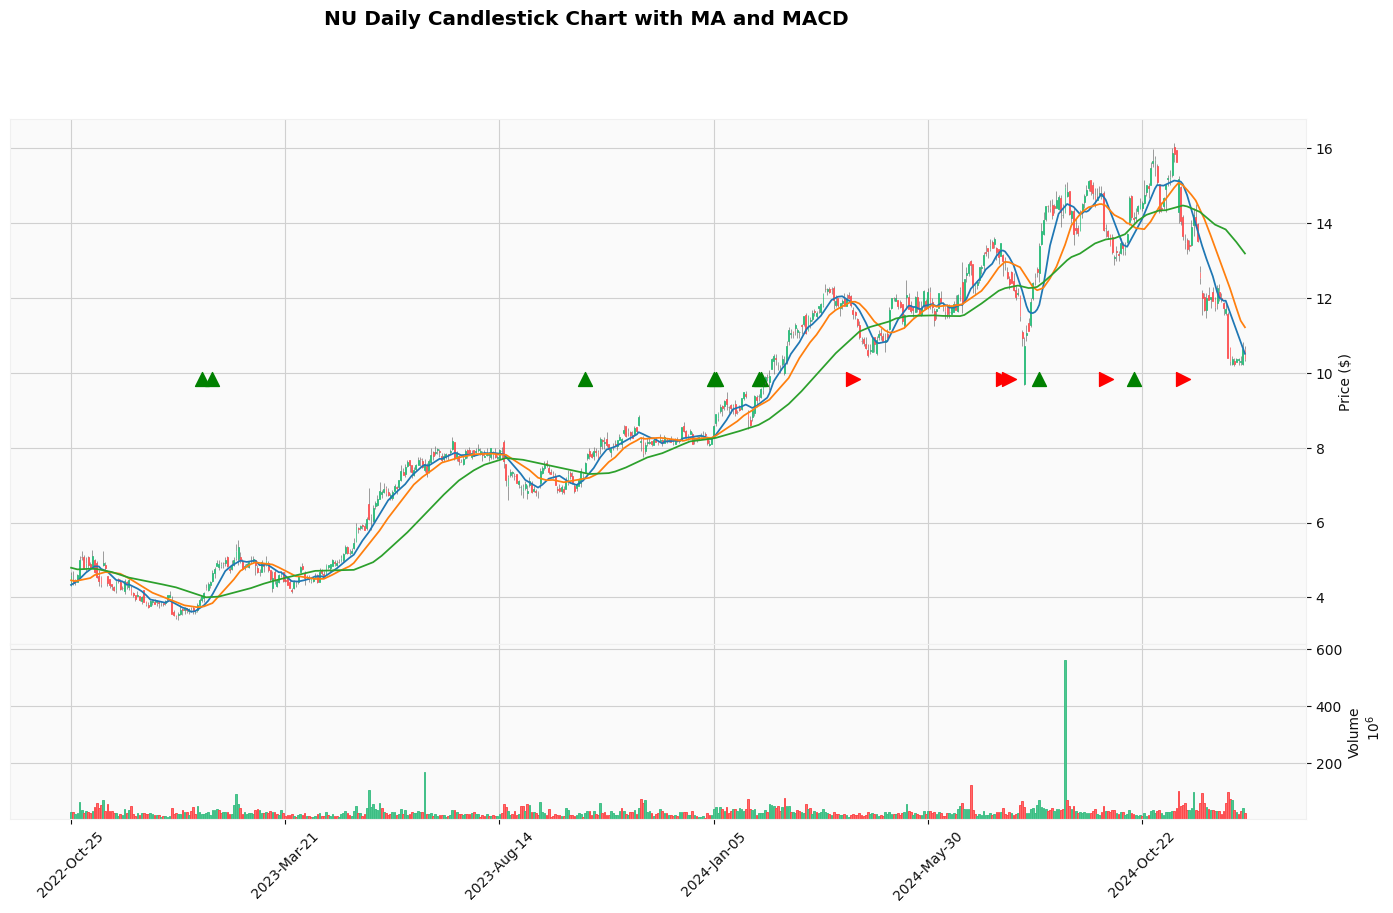

In [8]:
stock = "NU"

df_test = get_stock_df(df_all, stock)
visualize_dataset(df_test,
                stock=stock,
                viz_label="trend_10days",
                viz_pred=False,
                plot_macd=False)

In [12]:
df_test.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Trading_Volume', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'J',
       'RSI_14', 'OBV', 'VWAP', 'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower',
       'ATR', 'MA_5_10_Crossover_Signal', 'MA_5_20_Crossover_Signal',
       'MA_5_50_Crossover_Signal', 'MA_10_20_Crossover_Signal',
       'MA_10_50_Crossover_Signal', 'MA_20_50_Crossover_Signal',
       'MACD_Crossover_Signal', 'RSI_Over_Bought_Signal',
       'VWAP_Crossover_Signal', 'BB_Signal', 'Price_Above_MA_5',
       'Price_Below_MA_5', 'Open_diff', 'High_diff', 'Low_diff', 'Close_diff',
       'Volume_diff', 'MA_5_diff', 'MA_10_diff', 'MA_20_diff', 'MA_50_diff',
       'daily_change', 'EPS_Estimate', 'EPS_Reported', 'Surprise(%)',
       'Earnings_Date', 'stock', '5days_max_close', '5days_max_duration',
       '5days_min_close', '5days_min_duration', 'trend_5days',
     

In [39]:
percentile = np.percentile(np.abs(df_test["daily_change"]), 99)
for N in [5, 10, 20, 30]:
    threshold = N * 0.2 * percentile
    print(threshold)

0.0320813772192359
0.0641627544384718
0.1283255088769436
0.1924882633154154


In [6]:
from feature.feature import create_batch_feature, feature_names
from data.label import label_columns, label_feature, buy_sell_signals
from data.indicator import add_buy_sell_signals

In [7]:
features, labels, dates = create_batch_feature(df_test)

Positive labels: [14 16 12 16]


In [8]:
def get_false_predictions(df, label_name, label=0):
    label_pred = label_name + "_pred"
    
    dates_correct, dates_false = [], []
    for date, row in df.iterrows():
        if not np.isnan(row[label_pred]) and row[label_name] == label and row[label_pred] == row[label_name]:
            dates_correct.append(date.strftime("%Y-%m-%d"))
        elif not np.isnan(row[label_pred]) and row[label_name] == label and row[label_pred] != row[label_name]:
            dates_false.append(date.strftime("%Y-%m-%d"))
    return dates_correct, dates_false
    

dates_tf, dates_ff = get_false_predictions(df_test, "trend_30days", label=0)
# print("True flat: "). # too many flat
# print(dates_tf)
print("False flat: ")
print(dates_ff)

dates_tp, dates_fp = get_false_predictions(df_test, "trend_30days", label=1)
print("True positives: ")
print(dates_tp)
print("False positives: ")
print(dates_fp)

dates_tn, dates_fn = get_false_predictions(df_test, "trend_30days", label=2)
print("True negatives: ") # Too many negatives
print(dates_tn)
print("False negatives: ")
print(dates_fn)

False flat: 
['2023-02-08', '2023-02-15', '2023-02-24', '2023-04-11', '2023-05-09', '2023-07-28', '2023-07-31', '2023-08-11', '2023-08-22', '2023-09-05', '2023-09-21', '2023-09-27', '2023-10-02', '2023-11-07', '2023-11-08', '2023-11-29', '2023-12-04', '2024-01-10', '2024-02-21', '2024-03-28', '2024-04-05', '2024-05-08', '2024-05-10', '2024-06-10', '2024-07-05', '2024-08-06', '2024-08-13', '2024-08-28', '2024-09-03', '2024-10-21', '2024-11-11', '2024-11-12', '2024-11-13', '2024-12-02', '2024-12-04']
True positives: 
['2022-12-29', '2022-12-30', '2023-03-15', '2023-04-27', '2023-04-28', '2023-05-18', '2023-06-15', '2023-09-01', '2023-10-05', '2023-11-06', '2023-12-14', '2023-12-15', '2024-05-01', '2024-08-02', '2024-09-16']
False positives: 
['2023-03-06']
True negatives: 
['2024-06-14', '2024-07-01', '2024-07-12', '2024-07-16']
False negatives: 
['2023-08-03', '2024-04-12']


In [23]:
label_pred = [label + "_pred" for label in label_feature]
df_test.loc[dates_ff, label_feature + label_pred].head(30)

,trend_10days,trend_20days,trend_30days,trend_60days,trend_10days_pred,trend_20days_pred,trend_30days_pred,trend_60days_pred
Date,,,,,,,,
2023-01-12,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-01-13,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-01-26,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-01-27,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-03-03,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-03-16,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-03-21,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2023-03-24,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2023-03-31,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0


In [80]:
columns = df_test.columns
# columns = [column for column in columns if "trend" in column or column in feature_names[18:]]
display(df_test.loc[['2023-03-15', '2023-03-24'], ["30days_max_close", "30days_min_close"]])
display(df_test.loc[['2023-03-15', '2023-03-24'], [column for column in columns if "trend" in column]])
display(df_test.loc[['2023-03-15', '2023-03-24'], [column for column in columns if column in feature_names[18:]]])

,30days_max_close,30days_min_close
Date,,
2023-03-15,0.111850,0.010811
2023-03-24,0.089983,-0.009070


,trend_10days+,trend_10days-,trend_20days+,trend_20days-,trend_30days+,trend_30days-,trend_10days+_pred,trend_10days-_pred,trend_20days+_pred,trend_20days-_pred,trend_30days+_pred,trend_30days-_pred,trend_10days+_prob,trend_10days-_prob,trend_20days+_prob,trend_20days-_prob,trend_30days+_prob,trend_30days-_prob
Date,,,,,,,,,,,,,,,,,,
2023-03-15,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.595323,0.448537,0.558518,0.423968,0.684183,0.548993
2023-03-24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.608527,0.446462,0.563953,0.415573,0.679375,0.530468


,MA_10_50_Crossover_Signal_-1,MA_10_50_Crossover_Signal_0,MA_10_50_Crossover_Signal_1,MA_5_20_Crossover_Signal_-1,MA_5_20_Crossover_Signal_0,MA_5_20_Crossover_Signal_1,MACD_Crossover_Signal_-1,MACD_Crossover_Signal_0,MACD_Crossover_Signal_1,RSI_Over_Bought_Signal_-1,RSI_Over_Bought_Signal_0,RSI_Over_Bought_Signal_1,BB_Signal_-1,BB_Signal_0,BB_Signal_1
Date,,,,,,,,,,,,,,,
2023-03-15,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
2023-03-24,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0


In [ ]:
column_30days = ['30days_max_close','30days_max_duration', '30days_min_close', '30days_min_duration','trend_30days+', 'trend_30days-']
df_test.loc[(df_test['trend_30days+'] == 1) | (df_test['trend_30days-'] == 1), column_30days + buy_sell_signals_encoded]

In [8]:
arr = np.random.rand(5, 12)

In [9]:
arr

array([[0.80718417, 0.2574237 , 0.4677844 , 0.7320044 , 0.79438184,
        0.81126962, 0.37395737, 0.00769282, 0.90116023, 0.30811353,
        0.50473437, 0.29442197],
       [0.83829619, 0.65194135, 0.81226104, 0.35566961, 0.83618649,
        0.78140189, 0.84333455, 0.45287723, 0.54895247, 0.21168218,
        0.4941404 , 0.0503131 ],
       [0.55033921, 0.07408125, 0.19317212, 0.49356982, 0.69302781,
        0.31988806, 0.27834019, 0.92831935, 0.18863549, 0.21993081,
        0.72610658, 0.27080369],
       [0.5466789 , 0.76550251, 0.00921611, 0.49144021, 0.85646669,
        0.73028275, 0.57828614, 0.4322826 , 0.2456955 , 0.40029831,
        0.99847681, 0.61301202],
       [0.78037418, 0.58061039, 0.92451201, 0.85183482, 0.65691964,
        0.4858996 , 0.68075061, 0.11308123, 0.62865301, 0.21037548,
        0.10949907, 0.04400041]])

In [11]:
arr.reshape(5 * 4, 3)

array([[0.80718417, 0.2574237 , 0.4677844 ],
       [0.7320044 , 0.79438184, 0.81126962],
       [0.37395737, 0.00769282, 0.90116023],
       [0.30811353, 0.50473437, 0.29442197],
       [0.83829619, 0.65194135, 0.81226104],
       [0.35566961, 0.83618649, 0.78140189],
       [0.84333455, 0.45287723, 0.54895247],
       [0.21168218, 0.4941404 , 0.0503131 ],
       [0.55033921, 0.07408125, 0.19317212],
       [0.49356982, 0.69302781, 0.31988806],
       [0.27834019, 0.92831935, 0.18863549],
       [0.21993081, 0.72610658, 0.27080369],
       [0.5466789 , 0.76550251, 0.00921611],
       [0.49144021, 0.85646669, 0.73028275],
       [0.57828614, 0.4322826 , 0.2456955 ],
       [0.40029831, 0.99847681, 0.61301202],
       [0.78037418, 0.58061039, 0.92451201],
       [0.85183482, 0.65691964, 0.4858996 ],
       [0.68075061, 0.11308123, 0.62865301],
       [0.21037548, 0.10949907, 0.04400041]])

In [15]:
b = arr.reshape(5, 4, 3)

In [16]:
b[:,0, :]

array([[0.80718417, 0.2574237 , 0.4677844 ],
       [0.83829619, 0.65194135, 0.81226104],
       [0.55033921, 0.07408125, 0.19317212],
       [0.5466789 , 0.76550251, 0.00921611],
       [0.78037418, 0.58061039, 0.92451201]])